In [124]:
# Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp

from imblearn.over_sampling import SMOTE
from itertools import cycle

% matplotlib inline

# Data pre-processing

In [17]:
# Imorting train dataset
df = pd.read_csv("train.csv")
print('Brief exploration of the dataset:')
print('')
print(df.describe().round(1))

Brief exploration of the dataset:

            x1       x2       x3       x4       x5       y1       y2       y3  \
count  38829.0  38829.0  38829.0  38829.0  38829.0  38829.0  38829.0  38829.0   
mean       0.5      0.3      0.8      0.4      0.3      0.2      0.2      0.3   
std        0.2      0.2      0.2      0.2      0.2      0.1      0.1      0.1   
min        0.0      0.0      0.2      0.0      0.0      0.0      0.0      0.0   
25%        0.2      0.1      0.6      0.2      0.1      0.1      0.0      0.2   
50%        0.4      0.3      0.8      0.4      0.3      0.2      0.1      0.3   
75%        0.7      0.5      0.9      0.6      0.5      0.3      0.3      0.3   
max        1.0      1.0      1.0      1.0      1.0      0.6      0.8      1.0   

            y4       y5       y6       z1       z2       z3       z4       z5  \
count  38829.0  38829.0  38829.0  38829.0  38829.0  38829.0  38829.0  38829.0   
mean       0.6      0.5      0.8      0.4      0.5      0.5      0.1     

By exploring the dataset, it is understood that there is no error or duplicated value. Moreover, no missing value was found. It is worth mentioning that all features are continuous and scaled. Nevertheless, it is important to study whether there are outliers in either features or target variables.  This will be explored later on.

# Exploratory analysis

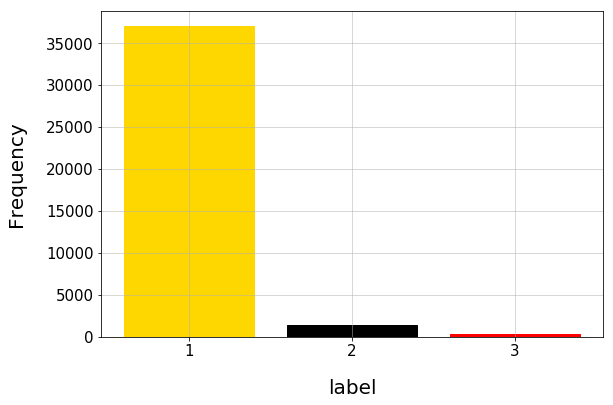

In [147]:
# Exploring the frequency of each target variable
plt.figure(figsize=(9,6))

barlist=plt.bar(df.groupby("label")["x1"].count().index, 
                df.groupby("label")["x1"].count().values)
barlist[0].set_color('gold')
barlist[1].set_color('black')
barlist[2].set_color('red')

plt.xlabel('label', size=20, labelpad=20)
plt.ylabel('Frequency', size=20, labelpad=20)
plt.xticks([1,2,3], rotation=0, size=15)
plt.yticks(size=15)
plt.grid(True, linewidth=0.5)
plt.show()

As seen in the plot, the occurrence of classes differs significantly, making this problem a highly imbalanced classification problem.

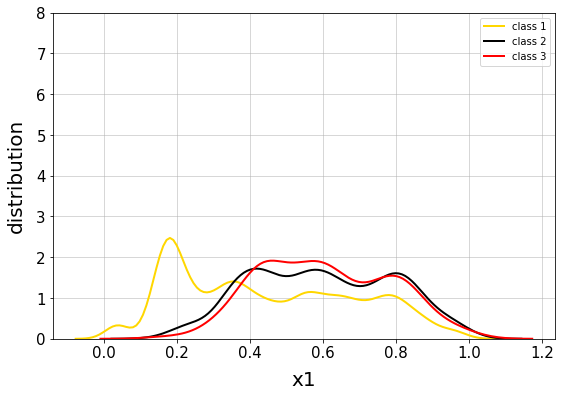

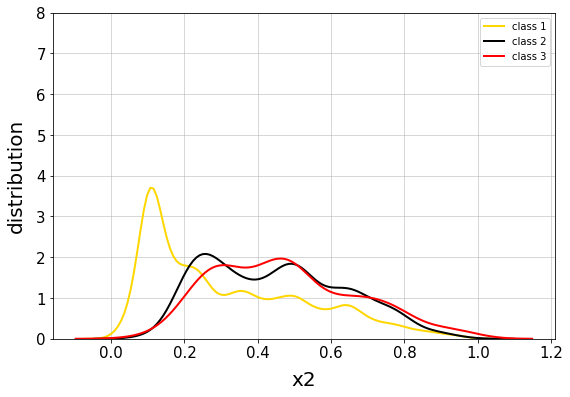

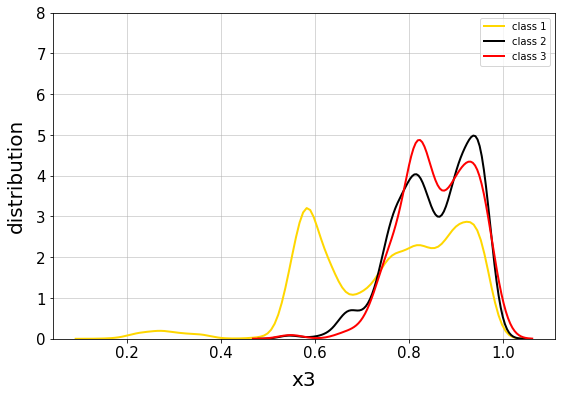

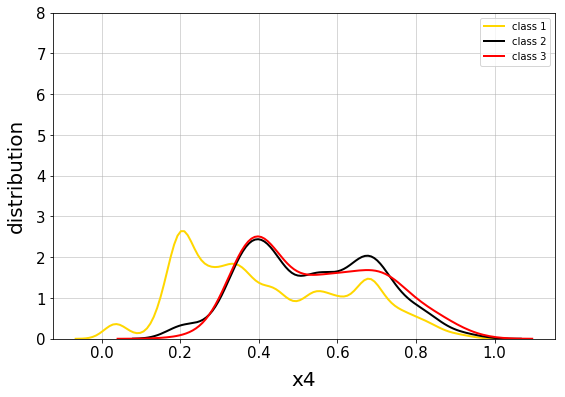

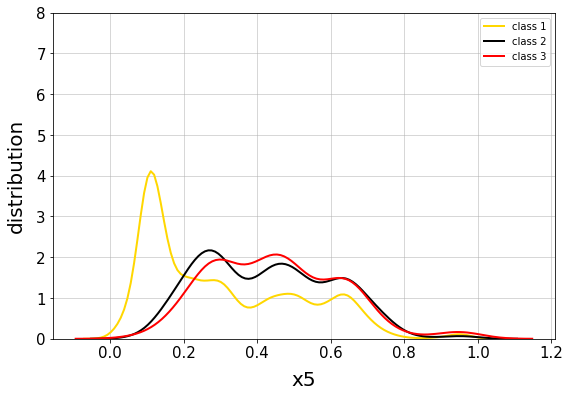

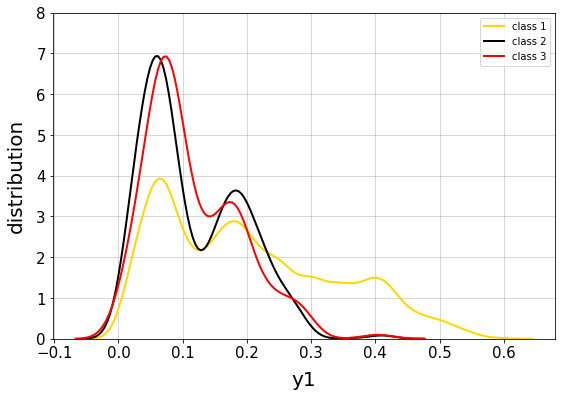

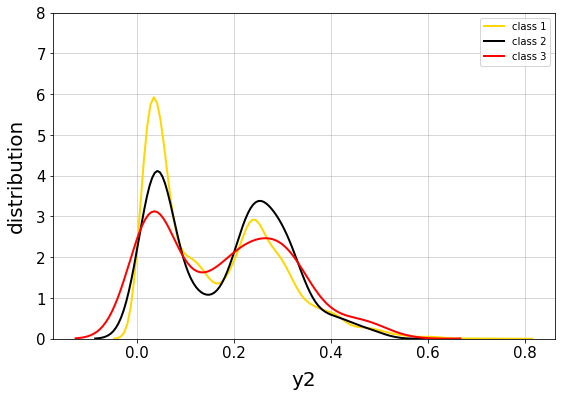

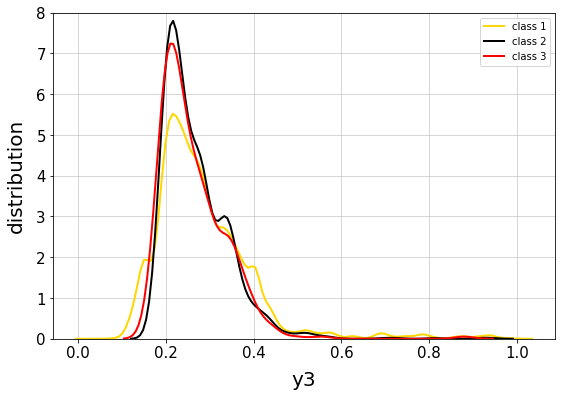

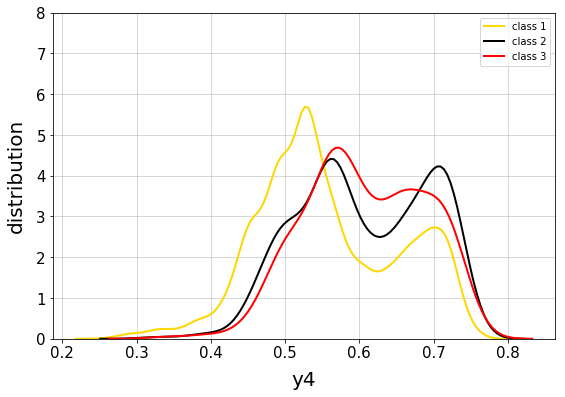

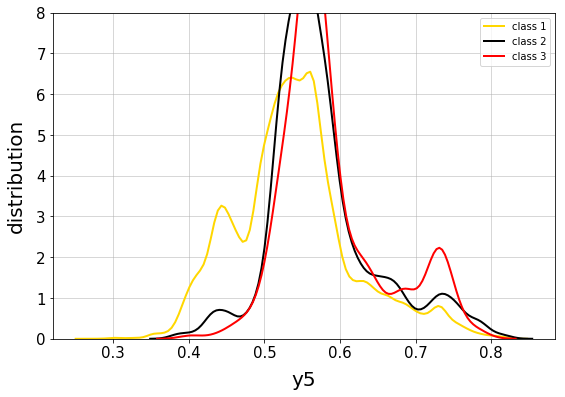

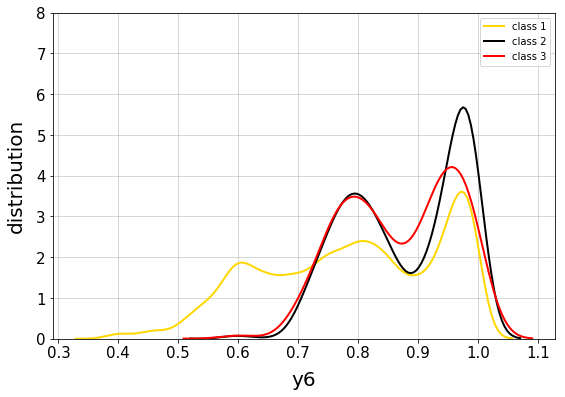

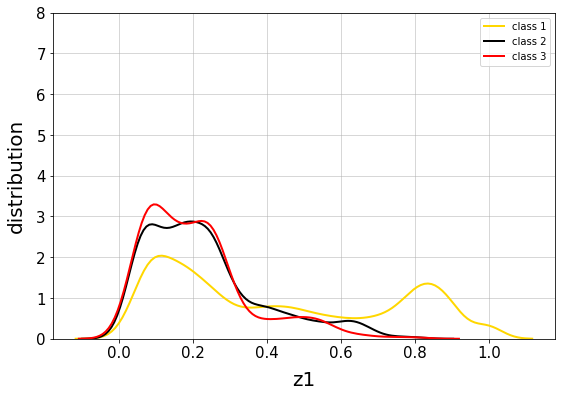

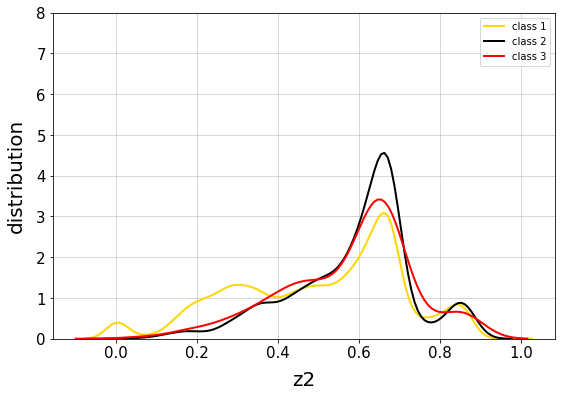

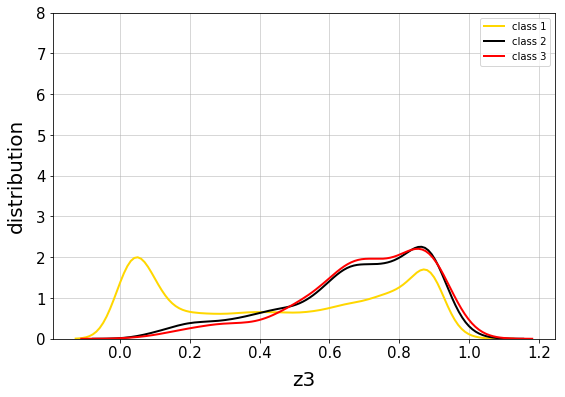

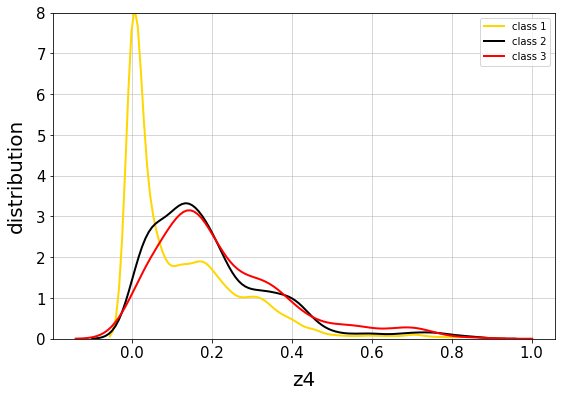

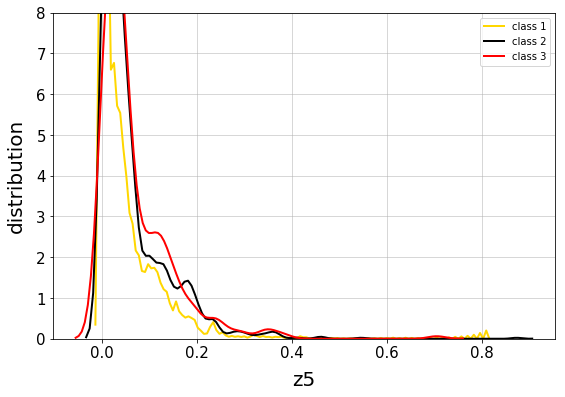

In [70]:
# Exploring the distribution of features for each class
for col in df.columns[0:-1]:
    plt.figure(figsize=(9,6))
    sns.distplot(df.loc[df["label"]==1,col], color="gold", hist=False, kde_kws={"lw": 2, "label": "class 1"})
    sns.distplot(df.loc[df["label"]==2,col], color="black", hist=False, kde_kws={"lw": 2, "label": "class 2"})
    sns.distplot(df.loc[df["label"]==3,col], color="red", hist=False, kde_kws={"lw": 2, "label": "class 3"})
    plt.xlabel(col, size=20, labelpad=10)
    plt.ylabel('distribution',size=20, labelpad=10)
    plt.ylim(0,8)
    plt.xticks(rotation=0, size=15)
    plt.yticks(size=15)
    plt.grid(True, linewidth=0.5)
    plt.show()

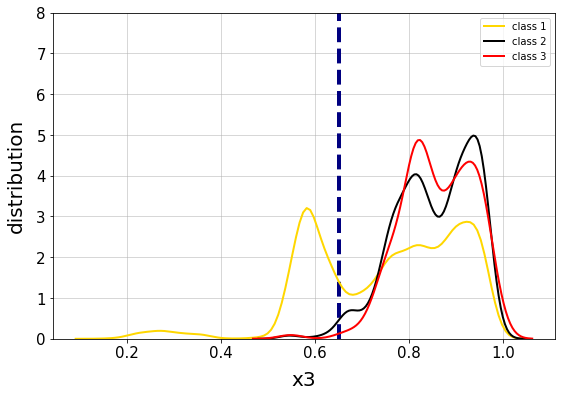

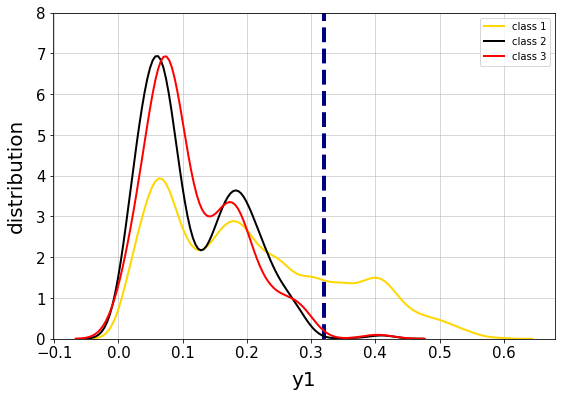

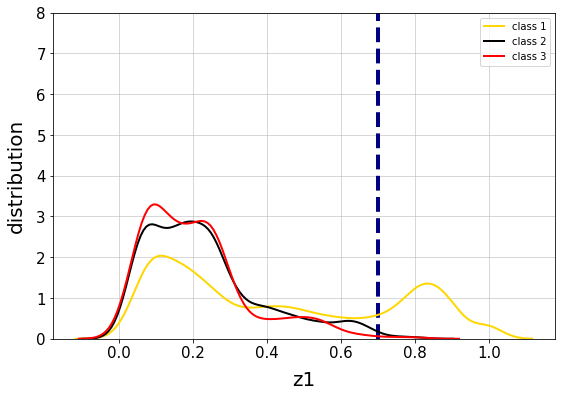

In [73]:
# Adding threshold two selected features distribution plot
for col in ["x3", "y1", "z1"]:
    plt.figure(figsize=(9,6))
    sns.distplot(df.loc[df["label"]==1,col], color="gold", hist=False, kde_kws={"lw": 2, "label": "class 1"})
    sns.distplot(df.loc[df["label"]==2,col], color="black", hist=False, kde_kws={"lw": 2, "label": "class 2"})
    sns.distplot(df.loc[df["label"]==3,col], color="red", hist=False, kde_kws={"lw": 2, "label": "class 3"})
    if col == "x3":
        vline_x = 0.65
    elif col == "y1":
        vline_x = 0.32
    else:
        vline_x = 0.7
    plt.vlines(x=vline_x, ymin=0, ymax=8, linestyles='--', colors='navy', linewidth=4)
    plt.xlabel(col, size=20, labelpad=10)
    plt.ylabel('distribution',size=20, labelpad=10)
    plt.ylim(0,8)
    plt.xticks(rotation=0, size=15)
    plt.yticks(size=15)
    plt.grid(True, linewidth=0.5)
    plt.show()

In [74]:
# Exploring the correlation between features
print(df.corr())

             x1        x2        x3        x4        x5        y1        y2  \
x1     1.000000  0.942813  0.927757  0.975880  0.939354 -0.864291  0.641827   
x2     0.942813  1.000000  0.877905  0.947798  0.986465 -0.798556  0.610528   
x3     0.927757  0.877905  1.000000  0.927875  0.883329 -0.802608  0.577043   
x4     0.975880  0.947798  0.927875  1.000000  0.946893 -0.821383  0.681585   
x5     0.939354  0.986465  0.883329  0.946893  1.000000 -0.790807  0.623059   
y1    -0.864291 -0.798556 -0.802608 -0.821383 -0.790807  1.000000 -0.540432   
y2     0.641827  0.610528  0.577043  0.681585  0.623059 -0.540432  1.000000   
y3     0.085215 -0.019353 -0.005032  0.065744 -0.040071 -0.173110  0.414822   
y4     0.770174  0.823287  0.760328  0.778773  0.840454 -0.654840  0.398865   
y5     0.665552  0.762262  0.588635  0.669506  0.736632 -0.634905  0.435564   
y6     0.912881  0.828448  0.936386  0.902226  0.832208 -0.917538  0.623529   
z1    -0.940035 -0.862663 -0.935184 -0.915304 -0.859

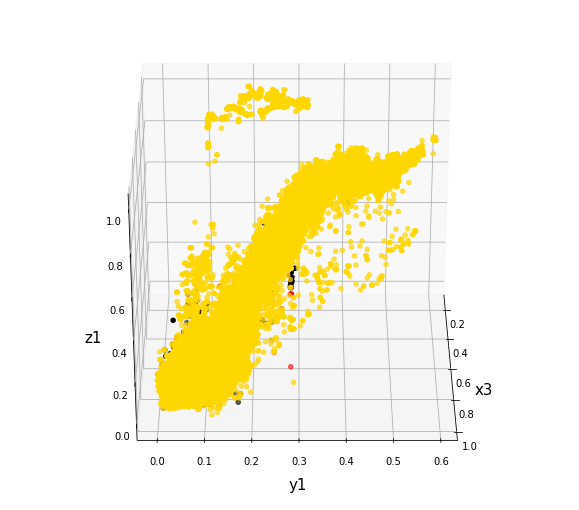

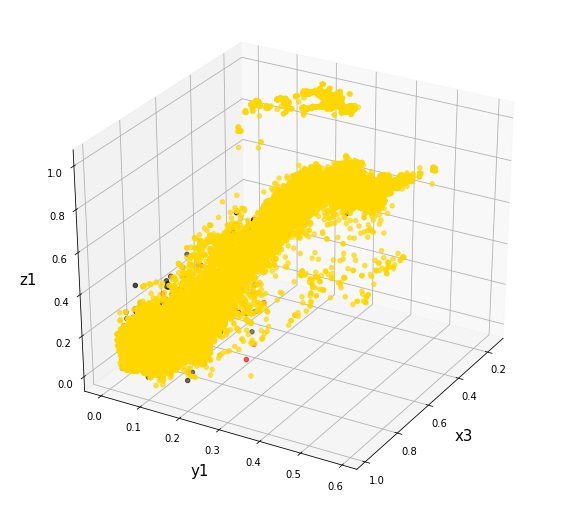

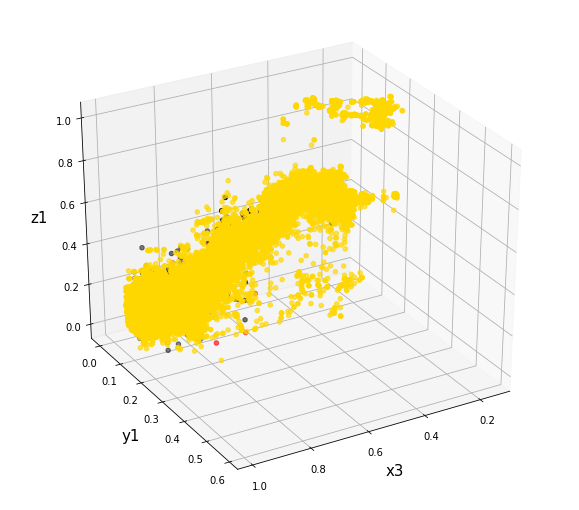

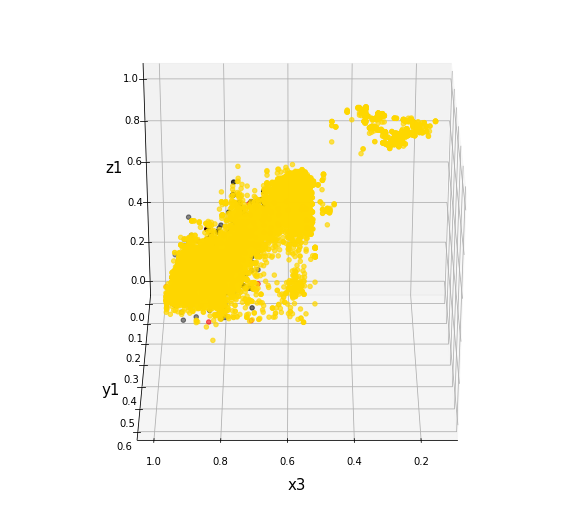

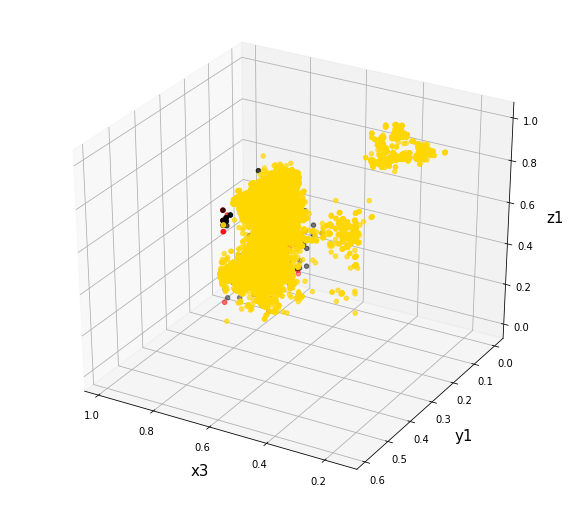

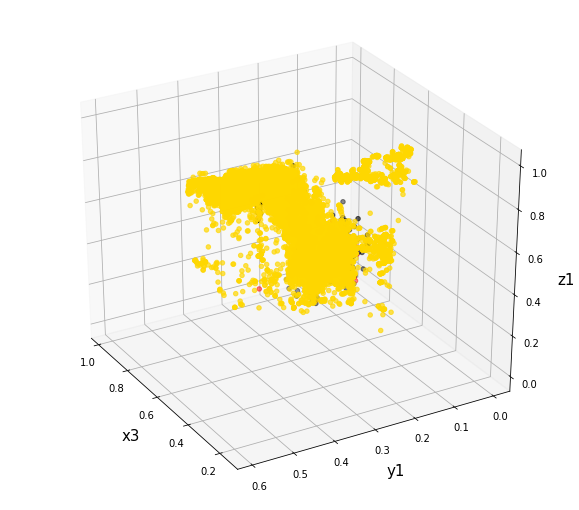

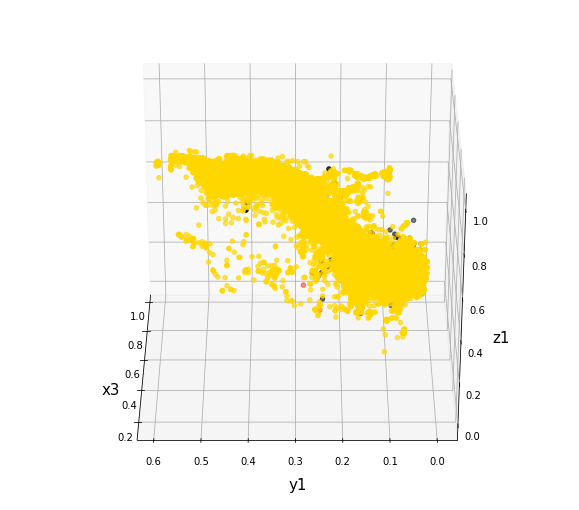

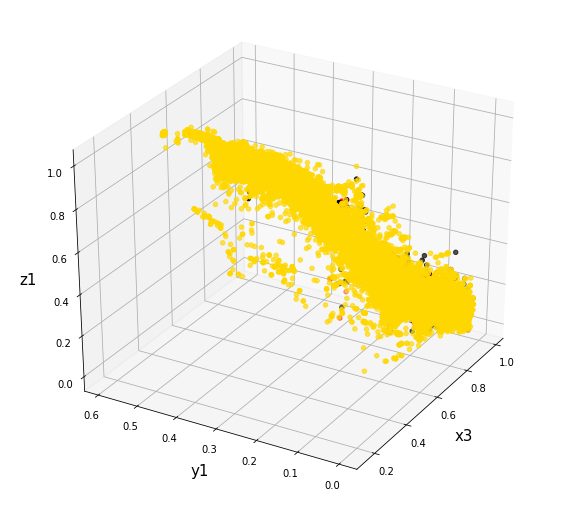

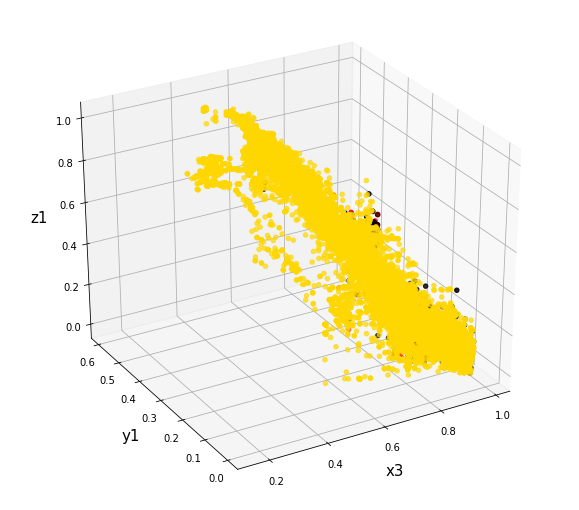

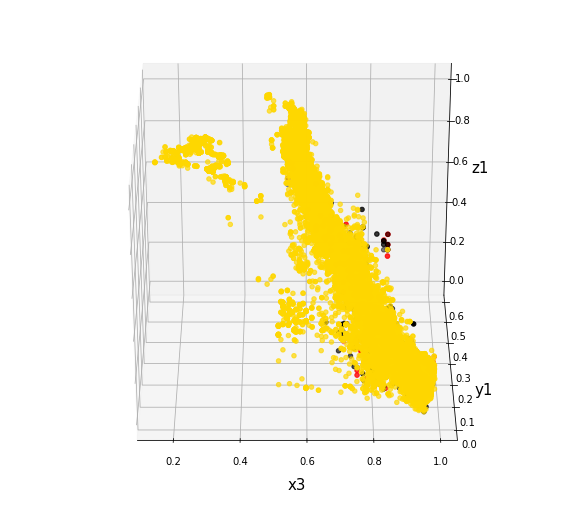

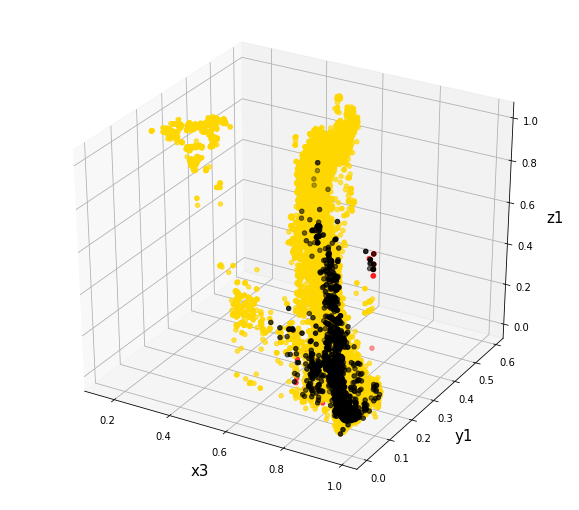

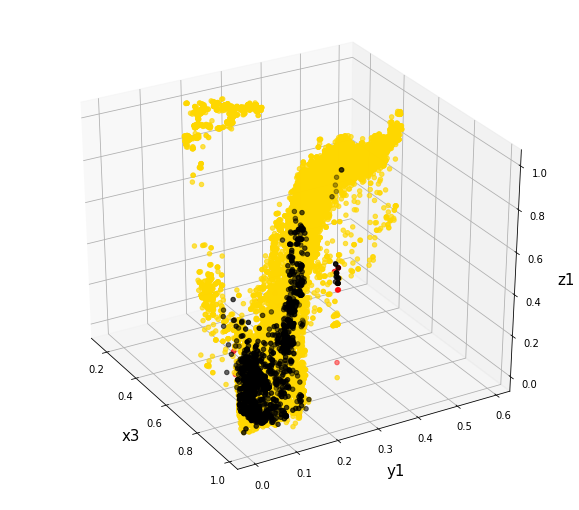

In [81]:
# Visualizing three classes in 3-dimensions
for angle in range(0, 360, 30):
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df[df["label"]==1]["x3"], df[df["label"]==1]["y1"], df[df["label"]==1]["z1"], color="gold", alpha=0.7)
    ax.scatter(df[df["label"]==2]["x3"], df[df["label"]==2]["y1"], df[df["label"]==2]["z1"], color="black")
    ax.scatter(df[df["label"]==3]["x3"], df[df["label"]==3]["y1"], df[df["label"]==3]["z1"], color="red")
    ax.set_xlabel('x3', size=15, labelpad=10)
    ax.set_ylabel('y1', size=15, labelpad=10)
    ax.set_zlabel('z1', size=15, labelpad=10)
    ax.view_init(30,angle)
    plt.show()

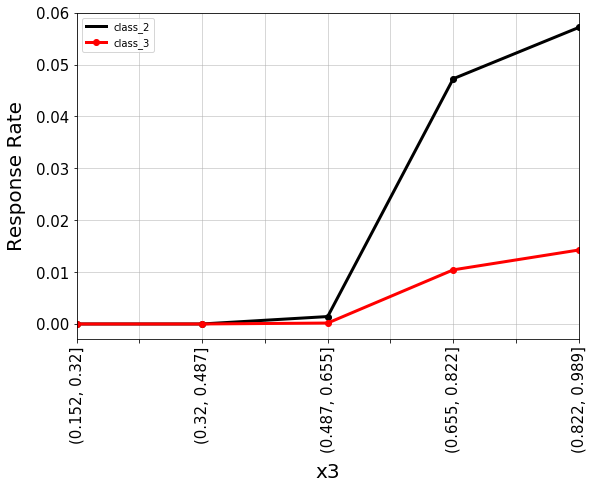

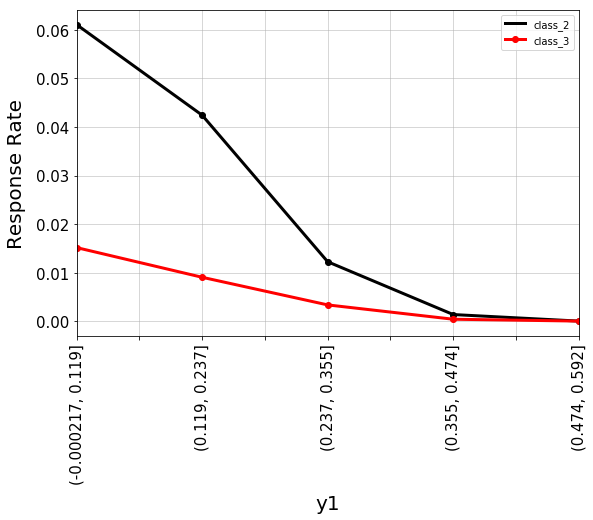

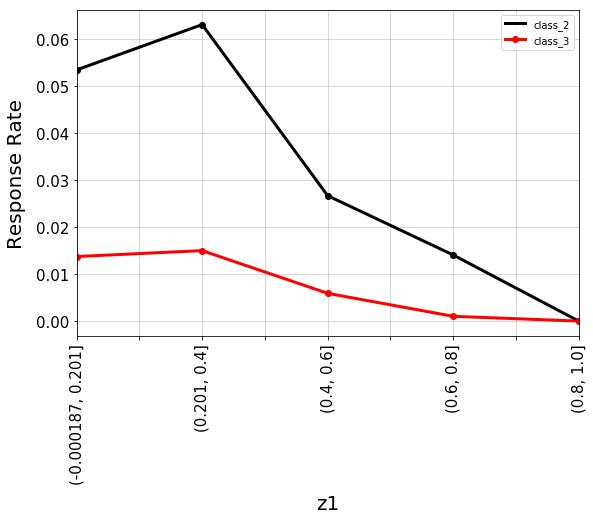

In [94]:
# Investigating the impact of features on the target variable
df["class_1"] = list(map(lambda x: 1 if x==1 else 0, df["label"]))
df["class_2"] = list(map(lambda x: 1 if x==2 else 0, df["label"]))
df["class_3"] = list(map(lambda x: 1 if x==3 else 0, df["label"]))


for col in ["x3", "y1", "z1"]:
    plt.figure(figsize=(9,6))
    
    (df.groupby(pd.cut(df[col], bins=5))["class_2"].sum()/\
    df.groupby(pd.cut(df[col], bins=5))["class_2"].count()).plot(kind="line", 
                                                                 color="black", 
                                                                 marker="o", 
                                                                 linewidth=3,
                                                                 legend=True)
    
    (df.groupby(pd.cut(df[col], bins=5))["class_3"].sum()/\
    df.groupby(pd.cut(df[col], bins=5))["class_3"].count()).plot(kind="line", 
                                                                 color="red", 
                                                                 marker="o", 
                                                                 linewidth=3, 
                                                                 legend=True)
    
    plt.xlabel(col, size=20, labelpad=10)
    plt.ylabel('Response Rate',size=20, labelpad=10)
    plt.xticks(rotation=90, size=15)
    plt.yticks(size=15)
    plt.grid(True, linewidth=0.5)
    plt.show()

# Dealing with imbalanced problem demonstration

In [128]:
# Creating a dataset with three selected features and the label
dataset = df.loc[:,["x3","y1","z1","label"]]
dataset.columns = ["x","y", "z", "label"]

# Removing few outliers
dataset.loc[(dataset["y"]>=0.31), "label"] = 1

# Defining features and target vectors
X = dataset.iloc[:, :-1].values
y = dataset.loc[:,"label"].values

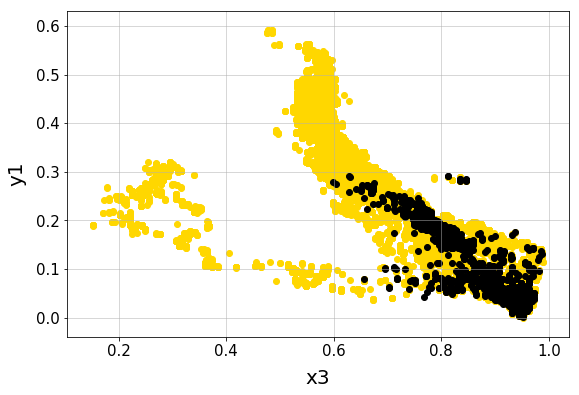

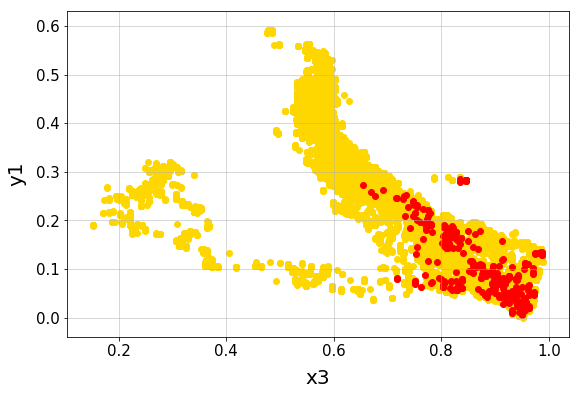

In [109]:
# Visualizing majority and minority classes BEFORE resampling
plt.figure(figsize=(9,6))
plt.scatter(X[y==1,0],X[y==1,1], color="gold")
plt.scatter(X[y==2,0],X[y==2,1], color="black")
plt.xlabel("x3", size=20, labelpad=10)
plt.ylabel("y1",size=20, labelpad=10)
plt.xticks(rotation=0, size=15)
plt.yticks(size=15)
plt.grid(True, linewidth=0.5)
plt.show()

plt.figure(figsize=(9,6))
plt.scatter(X[y==1,0],X[y==1,1], color="gold")
plt.scatter(X[y==3,0],X[y==3,1], color="red")
plt.xlabel("x3", size=20, labelpad=10)
plt.ylabel("y1",size=20, labelpad=10)
plt.xticks(rotation=0, size=15)
plt.yticks(size=15)
plt.grid(True, linewidth=0.5)
plt.show()

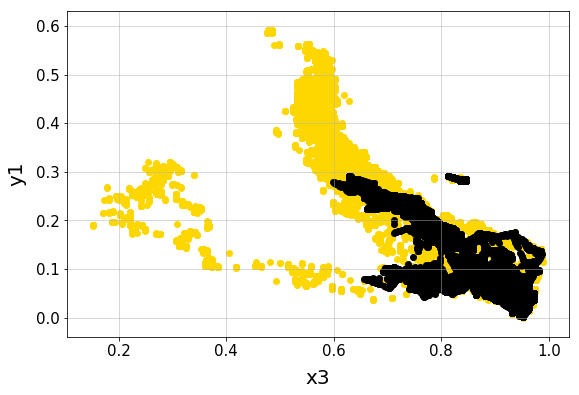

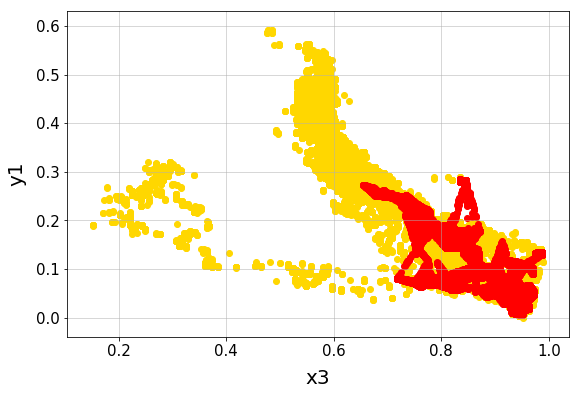

In [132]:
# Applying smote algorithm for visialization purposes
sm = SMOTE(ratio = {2:37000, 3:37000}, k_neighbors=5)
X_res, y_res = sm.fit_sample(X ,y)

# Visualizing majority and minority classes AFTER resampling
plt.figure(figsize=(9,6))
plt.scatter(X_res[y_res==1,0],X_res[y_res==1,1], color="gold")
plt.scatter(X_res[y_res==2,0],X_res[y_res==2,1], color="black")
plt.xlabel("x3", size=20, labelpad=10)
plt.ylabel("y1",size=20, labelpad=10)
plt.xticks(rotation=0, size=15)
plt.yticks(size=15)
plt.grid(True, linewidth=0.5)
plt.show()

plt.figure(figsize=(9,6))
plt.scatter(X_res[y_res==1,0],X_res[y_res==1,1], color="gold")
plt.scatter(X_res[y_res==3,0],X_res[y_res==3,1], color="red")
plt.xlabel("x3", size=20, labelpad=10)
plt.ylabel("y1",size=20, labelpad=10)
plt.xticks(rotation=0, size=15)
plt.yticks(size=15)
plt.grid(True, linewidth=0.5)
plt.show()


# Developing data-driven classification algorithms

In [129]:
# Developing a data driven model for classifying the target value assuming all classes have same importance

# Defining a special function for calculating recall for multiclass
def special_recall(cm):
    r_1 = cm[0][0]/(cm[0][0] + cm[0][1] + cm[0][2])
    r_2 = cm[1][1]/(cm[1][0] + cm[1][1] + cm[1][2])
    r_3 = cm[2][2]/(cm[2][0] + cm[2][1] + cm[2][2])
    return (r_1, r_2, r_3)


list_of_classifiers = [AdaBoostClassifier(random_state=0),
                       RandomForestClassifier(n_estimators=50, random_state=0),
                       KNeighborsClassifier()]

# Creating stratified k folds
skf = StratifiedKFold(y=y, n_folds=5, random_state=0, shuffle=True)

# Creating SMOTE object
sm = SMOTE(ratio = {2:27000, 3:27000}, k_neighbors=5)

for clf in list_of_classifiers:
    classifier = clf
    recall_values = []
    for train_index, test_index in skf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train_res, y_train_res = sm.fit_sample(X_train ,y_train)
        classifier.fit(X_train_res, y_train_res)
        y_pred = classifier.predict(X_test)
        recall = special_recall(confusion_matrix(y_test, y_pred))
        recall_values.append(recall)
    avg_recall = (np.mean([x[0] for x in recall_values]),
                  np.mean([x[1] for x in recall_values]),
                  np.mean([x[2] for x in recall_values]))
    decision_factor = avg_recall[0] * avg_recall[1] * avg_recall[2]
    print('classifier: {}'.format(clf))
    print('')
    print('average recall for all classes: {}'.format(avg_recall))
    print('')
    print('descision factor: {}'.format(decision_factor))
    print('----------------------------------------')
    

classifier: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=0)

average recall for all classes: (0.47727563951562546, 0.54684964913153833, 0.52194907813871816)

descision factor: 0.13622767385148848
----------------------------------------
classifier: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

average recall for all classes: (0.93858052806367132, 0.2994948489523715, 0.14811237928007023)

descision factor: 0.041634394774736246
----------------------------------------
classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
        

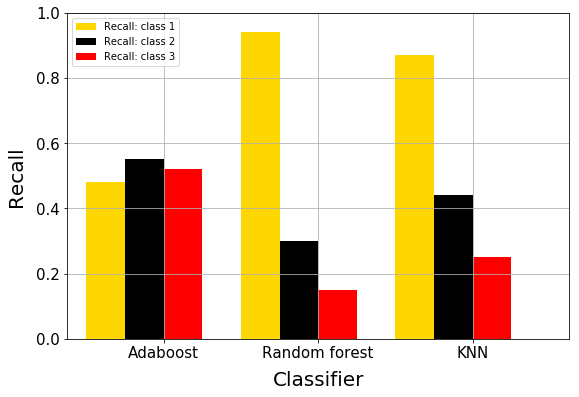

In [130]:
# Visualizing the recall values and comparing them for different classifiers

raw_data = {'classifier': ['Adaboost', 'Random forest', 'KNN'],
        'Recall: class 1': [0.48, 0.94, 0.87],
        'Recall: class 2': [0.55, 0.3, 0.44],
        'Recall: class 3': [0.52, 0.15, 0.25]}
eval_df = pd.DataFrame(raw_data, columns = ['classifier', 'Recall: class 1', 'Recall: class 2', 'Recall: class 3'])
eval_df

pos = list(range(len(eval_df['Recall: class 1']))) 
width = 0.25 

# Plotting the bars
fig, ax = plt.subplots(figsize=(9,6))

plt.bar(pos, 
        eval_df['Recall: class 1'], 
        width, 
        alpha=1, 
        color='gold', 
        label=eval_df['classifier'][0]) 

plt.bar([p + width for p in pos], 
        eval_df['Recall: class 2'],
        width, 
        alpha=1, 
        color='black', 
        label=eval_df['classifier'][1]) 

plt.bar([p + width*2 for p in pos], 
        eval_df['Recall: class 3'], 
        width, 
        alpha=1, 
        color='red',
        label=eval_df['classifier'][2]) 

ax.set_ylabel('Score')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(eval_df['classifier'])

plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 1] )
plt.xlabel('Classifier', size=20, labelpad=10)
plt.ylabel('Recall', size= 20, labelpad=10)
plt.xticks(rotation=0, size=15)
plt.yticks(size=15)
plt.legend(['Recall: class 1', 'Recall: class 2', 'Recall: class 3'], loc='upper left')
plt.grid(True)
plt.show()


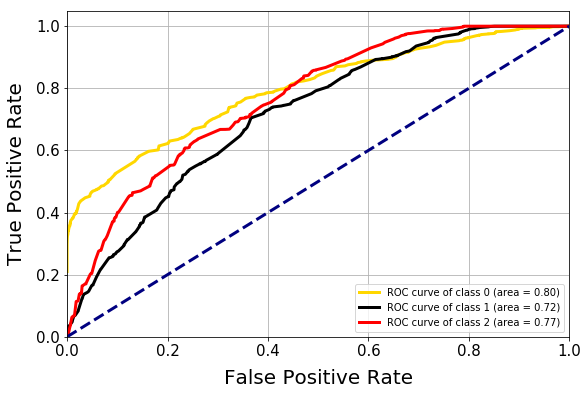

In [134]:
# Pltting ROC curve for Adaboost classifier 
# ****Please note that some parts of this code block is obtained from sklearn website****

# Binarize the y
y_res = label_binarize(y_res, classes=[1,2,3])
n_classes = y_res.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.5, random_state=0)
# Defining the classifier
classifier = OneVsRestClassifier(AdaBoostClassifier(random_state=0))

# Defining y score
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Computing ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Computing micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plotting ROC curves
plt.figure(figsize=(9,6))

colors = cycle(['gold', 'black', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=3,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color="navy", linestyle='--', lw=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=20, labelpad=10)
plt.ylabel('True Positive Rate', size= 20, labelpad=10)
plt.xticks(rotation=0, size=15)
plt.yticks(size=15)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [131]:
# Applying one-vs-all strategy

for clf in list_of_classifiers:
    classifier = OneVsRestClassifier(clf)
    recall_values = []
    for train_index, test_index in skf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train_res, y_train_res = sm.fit_sample(X_train ,y_train)
        classifier.fit(X_train_res, y_train_res)
        y_pred = classifier.predict(X_test)
        recall = special_recall(confusion_matrix(y_test, y_pred))
        recall_values.append(recall)
    avg_recall = (np.mean([x[0] for x in recall_values]),
                  np.mean([x[1] for x in recall_values]),
                  np.mean([x[2] for x in recall_values]))
    decision_factor = avg_recall[0] * avg_recall[1] * avg_recall[2]
    print('classifier: {}'.format(clf))
    print('')
    print('average recall for all classes: {}'.format(avg_recall))
    print('')
    print('descision factor: {}'.format(decision_factor))
    print('----------------------------------------')

classifier: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=0)

average recall for all classes: (0.51514563488259435, 0.51584133777932606, 0.54872695346795441)

descision factor: 0.14581508639651986
----------------------------------------
classifier: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

average recall for all classes: (0.93841873760000249, 0.29102921415418309, 0.16009657594381035)

descision factor: 0.043723538432350835
----------------------------------------
classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
       

In [156]:
# Developing the data-driven model for classes with different importance
# run this code multiple times
df = pd.read_csv("train.csv")
dataset = df.loc[:,["x3","y1","z1","label"]]
dataset.columns = ["x","y", "z", "label"]

# Defining features and target vectors
X = dataset.iloc[:, :-1].values
y = dataset.loc[:,"label"].values

skf = StratifiedKFold(y=y, n_folds=5, random_state=0, shuffle=True)

for w_2 in np.arange(50000,70001,5000):
    for w_3 in np.arange(70000,90001,10000):
        print('w_2 is {} and w_3 is {}:'.format(w_2, w_3))
        print('')
        sm = SMOTE(ratio = {2:w_2, 3:w_3}, k_neighbors=5)
        classifier = AdaBoostClassifier(random_state=0)
        recall_values = []
        for train_index, test_index in skf:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            X_train_res, y_train_res = sm.fit_sample(X_train ,y_train)
            classifier.fit(X_train_res, y_train_res)
            y_pred = classifier.predict(X_test)
            recall = special_recall(confusion_matrix(y_test, y_pred))
            recall_values.append(recall)      
        avg_recall = (np.mean([x[0] for x in recall_values]),
                      np.mean([x[1] for x in recall_values]),
                      np.mean([x[2] for x in recall_values]))
        decision_factor = avg_recall[0] * avg_recall[1] * avg_recall[2]
        print('average recall: {}'.format(avg_recall))
        print('--------------------------')

w_2 is 50000 and w_3 is 70000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (50000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (50000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.39329274813597764, 0.37234449760765548, 0.68687445127304658)
--------------------------
w_2 is 50000 and w_3 is 80000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (50000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (80000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (50000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (80000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.39143110631990924, 0.30432094221567907, 0.76360842844600529)
--------------------------
w_2 is 50000 and w_3 is 90000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (50000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (90000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (50000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (90000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.38144838464013098, 0.21317875107348794, 0.82273924495171202)
--------------------------
w_2 is 55000 and w_3 is 70000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (55000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (55000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.37613337925548884, 0.44599926389400074, 0.66325724319578572)
--------------------------
w_2 is 55000 and w_3 is 80000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (55000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (80000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (55000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (80000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.37974859512638381, 0.35410379094589628, 0.71044776119402986)
--------------------------
w_2 is 55000 and w_3 is 90000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (55000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (90000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (55000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (90000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.38128664153760888, 0.29307078886026255, 0.77247585601404745)
--------------------------
w_2 is 60000 and w_3 is 70000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (60000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (60000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.37589036238244544, 0.52521653784811684, 0.60149253731343288)
--------------------------
w_2 is 60000 and w_3 is 80000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (60000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (80000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (60000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (80000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.37821101827429515, 0.40041958041958042, 0.67809482001755916)
--------------------------
w_2 is 60000 and w_3 is 90000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (60000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (90000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (60000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (90000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.37551265119713195, 0.34288062814378606, 0.71949078138718181)
--------------------------
w_2 is 65000 and w_3 is 70000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (65000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (65000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.37416395359765653, 0.56026745184639926, 0.56312554872695342)
--------------------------
w_2 is 65000 and w_3 is 80000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (65000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (80000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (65000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (80000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.3749730294696042, 0.46139614771193721, 0.62497805092186121)
--------------------------
w_2 is 65000 and w_3 is 90000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (65000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (90000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (65000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (90000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.36949616086266091, 0.38497362286835968, 0.698595258999122)
--------------------------
w_2 is 70000 and w_3 is 70000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.36617757168621018, 0.63040117776959881, 0.50127304653204574)
--------------------------
w_2 is 70000 and w_3 is 80000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (80000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (80000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.36480156321696489, 0.53992638940007365, 0.58678665496049176)
--------------------------
w_2 is 70000 and w_3 is 90000:



C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (90000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (70000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 29651)
  n_samples_majority))
C:\Users\COE User\Anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (90000) in class 3 will be larger than the number of samples in the majority c

average recall: (0.3590005968861022, 0.42915470494417862, 0.67216856892010546)
--------------------------


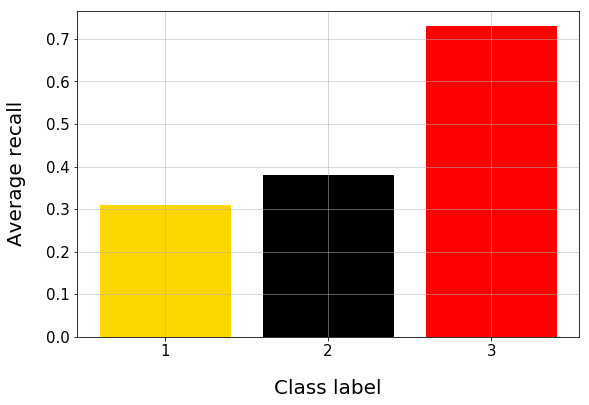

In [155]:
# Illustrating the recall values
plt.figure(figsize=(9,6))

barlist=plt.bar([1,2,3], [0.31,0.38,0.73])
barlist[0].set_color('gold')
barlist[1].set_color('black')
barlist[2].set_color('red')

plt.xlabel('Class label', size=20, labelpad=20)
plt.ylabel('Average recall', size=20, labelpad=20)
plt.xticks([1,2,3], rotation=0, size=15)
plt.yticks(size=15)
plt.grid(True, linewidth=0.5)
plt.savefig("test2.jpeg", format='jpeg')
plt.show()

# Seperate code blocks for getting predicted labels for all three parts

In [ ]:
### Code for getting the predicted labels for part 1 of the project ###

# creating a dataset with three selected features and the label
df = pd.read_csv("train.csv")
dataset = df.loc[:,["x3","y1","z1","label"]]
dataset.columns = ["x","y", "z", "label"]

# removing few outliers
dataset.loc[(dataset["y"]>=0.31), "label"] = 1

# Defining features and target vectors
X = dataset.iloc[:, :-1].values
y = dataset.loc[:,"label"].values

sm = SMOTE(ratio = {2:37000, 3:37000}, k_neighbors=5)
X_res, y_res = sm.fit_sample(X ,y)

classifier = AdaBoostClassifier(random_state=0)
classifier.fit(X_res,y_res)

test_df = pd.read_csv("test.csv", usecols=["x3", "y1", "z1"])
X_test = test_df.iloc[:,:].values
y_pred = classifier.predict(X_test)

pd.Series(y_pred).to_frame(name="predicted_label").to_csv("predicted_labels_1.csv", index=False)

In [ ]:
### Code for getting the predicted labels for part 2 of the project ###

# creating a dataset with three selected features and the label
df = pd.read_csv("train.csv")
dataset = df.loc[:,["x3","y1","z1","label"]]
dataset.columns = ["x","y", "z", "label"]

# removing few outliers
dataset.loc[(dataset["y"]>=0.31), "label"] = 1

# Defining features and target vectors
X = dataset.iloc[:, :-1].values
y = dataset.loc[:,"label"].values

sm = SMOTE(ratio = {2:37000, 3:37000}, k_neighbors=5)
X_res, y_res = sm.fit_sample(X ,y)

classifier = OneVsRestClassifier(AdaBoostClassifier(random_state=0))
classifier.fit(X_res,y_res)

test_df = pd.read_csv("test.csv", usecols=["x3", "y1", "z1"])
X_test = test_df.iloc[:,:].values
y_pred = classifier.predict(X_test)


pd.Series(y_pred).to_frame(name="predicted_label").to_csv("predicted_labels_2.csv", index=False)

In [ ]:
### Code for getting the predicted labels for part 3 of the project ###

# creating a dataset with three selected features and the label
df = pd.read_csv("train.csv")
dataset = df.loc[:,["x3","y1","z1","label"]]
dataset.columns = ["x","y", "z", "label"]

# Defining features and target vectors
X = dataset.iloc[:, :-1].values
y = dataset.loc[:,"label"].values

sm = SMOTE(ratio = {2:65000, 3:90000}, k_neighbors=5)
X_res, y_res = sm.fit_sample(X ,y)

classifier = AdaBoostClassifier(random_state=0)
classifier.fit(X_res,y_res)

test_df = pd.read_csv("test.csv", usecols=["x3", "y1", "z1"])
X_test = test_df.iloc[:,:].values
y_pred = classifier.predict(X_test)


pd.Series(y_pred).to_frame(name="predicted_label").to_csv("predicted_labels_3.csv", index=False)